In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(set(''.join(words)))
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Build dataset

In [5]:
block_size = 3 # context length: how many characters we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop oldes element and append the new one

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Build embedding table C

In the paper, they have 17000 words, with each word as a 30-dimensional vector.

Here we have 27 characters. We will make each character an embedding vector too.

In [9]:
C = torch.randn((27, 2)) # 27 characters, each character will have a corresponding 2-dim embedding vector
C

tensor([[-2.1734, -0.9600],
        [-1.0819,  1.4586],
        [ 1.8410, -1.0094],
        [-0.0722, -0.2847],
        [-0.9561,  0.7399],
        [ 0.7908,  0.0993],
        [-0.2409, -0.2831],
        [ 0.0688,  0.1468],
        [ 0.8983, -0.1054],
        [-0.2077, -0.7731],
        [-0.7970, -0.7668],
        [ 0.5481, -0.7793],
        [ 0.9319,  0.5424],
        [-1.1554,  1.5480],
        [-0.2740,  0.5869],
        [-0.0207,  1.3309],
        [ 0.4114, -0.4480],
        [-1.1941, -1.1397],
        [-1.6162, -0.4752],
        [-0.2040,  0.6230],
        [-0.5736,  0.0622],
        [-0.1189,  1.3639],
        [-0.1505,  0.0996],
        [ 0.6102, -1.2525],
        [-1.9461, -0.6442],
        [ 0.3418, -1.7236],
        [ 0.3932, -0.7311]])

In [10]:
# First way to index into embedding lookup matrix C
C[5]

tensor([0.7908, 0.0993])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [12]:
# Matrix multiplication: 1 x 27, 27 x 2
# Notice the result is the same as indexing 5 into matrix C
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.7908, 0.0993])

In [13]:
"""
We can think of embedding layer C as a linear layer
C is the weight matrix
And the output is taken as-is (linear)

We convert the character into one-hot encoding
Then feed into this first embedding layer
The output will be the indexed embedding vector (shown right above)
"""

'\nWe can think of embedding layer C as a linear layer\nC is the weight matrix\nAnd the output is taken as-is (linear)\n\nWe convert the character into one-hot encoding\nThen feed into this first embedding layer\nThe output will be the indexed embedding vector (shown right above)\n'

In [14]:
# In PyTorch, we can index multiple rows
C[[5,6,7]]

tensor([[ 0.7908,  0.0993],
        [-0.2409, -0.2831],
        [ 0.0688,  0.1468]])

In [15]:
# In PyTorch, we can index multiple rows
C[torch.tensor([5,6,7])]

tensor([[ 0.7908,  0.0993],
        [-0.2409, -0.2831],
        [ 0.0688,  0.1468]])

In [16]:
# X = 32 x 3 (context)
C[X]

tensor([[[-2.1734, -0.9600],
         [-2.1734, -0.9600],
         [-2.1734, -0.9600]],

        [[-2.1734, -0.9600],
         [-2.1734, -0.9600],
         [ 0.7908,  0.0993]],

        [[-2.1734, -0.9600],
         [ 0.7908,  0.0993],
         [-1.1554,  1.5480]],

        [[ 0.7908,  0.0993],
         [-1.1554,  1.5480],
         [-1.1554,  1.5480]],

        [[-1.1554,  1.5480],
         [-1.1554,  1.5480],
         [-1.0819,  1.4586]],

        [[-2.1734, -0.9600],
         [-2.1734, -0.9600],
         [-2.1734, -0.9600]],

        [[-2.1734, -0.9600],
         [-2.1734, -0.9600],
         [-0.0207,  1.3309]],

        [[-2.1734, -0.9600],
         [-0.0207,  1.3309],
         [ 0.9319,  0.5424]],

        [[-0.0207,  1.3309],
         [ 0.9319,  0.5424],
         [-0.2077, -0.7731]],

        [[ 0.9319,  0.5424],
         [-0.2077, -0.7731],
         [-0.1505,  0.0996]],

        [[-0.2077, -0.7731],
         [-0.1505,  0.0996],
         [-0.2077, -0.7731]],

        [[-0.1505,  0

In [17]:
# For each element in context X, index it and get the embedding vector 2-dim
C[X].shape

torch.Size([32, 3, 2])

In [18]:
print(X[13, 2])
print(C[X][13, 2])
print(C[1])

tensor(1)
tensor([-1.0819,  1.4586])
tensor([-1.0819,  1.4586])


In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

# Build the first layer

In [20]:
# 6 is because we have 3 input vectors (according to our model diagram)
# Each vector is 2-dim

# 100 is the length of hidden layer
# It's a hyper-parameter, which we can play around and set

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [21]:
"""
What we want to do is:
- emb @ W1 + b1

But now, emb has dimension of 32 x 3 x 2
We need to make it into 32 x 6

Resource: https://pytorch.org/docs/stable/torch.html#indexing-slicing-joining-mutating-ops
"""

'\nWhat we want to do is:\n- emb @ W1 + b1\n\nBut now, emb has dimension of 32 x 3 x 2\nWe need to make it into 32 x 6\n\nResource: https://pytorch.org/docs/stable/torch.html#indexing-slicing-joining-mutating-ops\n'

In [22]:
# https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [23]:
# https://pytorch.org/docs/stable/generated/torch.unbind.html#torch.unbind
# unbind will return slices across the dimension
# In our case, it's a list (length 3) of matrices 32 x 2 (since we unbind the dim=1 which is 3)
# Then we concat these matrices by the dim=1, which will become a single matrix 32 x 6

# This is inefficient because we create new tensors (which mean new storage/memory)

torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [24]:
# ANOTHER BETTER WAY
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [25]:
a.shape

torch.Size([18])

In [26]:
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view
a.view([2, 9])

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [27]:
# This will work as long as the number of elements multiplied is the same as the original shape
a.view([3, 3, 2])

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [28]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

## Super important note

Resource: http://blog.ezyang.com/2019/05/pytorch-internals/

So the numbers are actually stored as a linear sequence

But in a tensor, it has internal attributes that dictate the logical view

So when we call tensor.view(), we are actually changing these attributes and not the real data

Read the blog post for more information!!!

In [29]:
# We can simply change the view of emb to [32, 6] in this case !!!
emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

## Hidden state

In [30]:
h = emb.view(32, 6) @ W1 + b1
h

tensor([[-0.7090, -1.8889,  7.2768,  ...,  3.9304,  2.7569, -1.0189],
        [-0.8784, -3.5821,  5.1468,  ...,  2.6142,  2.4276,  0.8652],
        [ 1.3513, -2.2935,  6.9777,  ...,  4.2449,  8.4667,  0.0715],
        ...,
        [ 2.9333, -0.5562, -3.0146,  ..., -1.5018,  1.2775, -3.8958],
        [-0.3816, -0.3535, -0.9399,  ..., -0.2754, -0.0401, -1.9325],
        [-0.3306,  1.7192,  5.6176,  ...,  2.1652,  0.5499, -0.5547]])

In [31]:
h.shape # 100 hidden states for each example

torch.Size([32, 100])

In [32]:
# When we use -1, PyTorch will infer about the dimension
# And because the other dim is 6, PyTorch will know this first dim is 32
h = emb.view(-1, 6) @ W1 + b1

# We can also write:
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [33]:
# With activation function
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.6100, -0.9553,  1.0000,  ...,  0.9992,  0.9920, -0.7694],
        [-0.7056, -0.9985,  0.9999,  ...,  0.9893,  0.9845,  0.6989],
        [ 0.8744, -0.9798,  1.0000,  ...,  0.9996,  1.0000,  0.0714],
        ...,
        [ 0.9944, -0.5051, -0.9952,  ..., -0.9055,  0.8558, -0.9992],
        [-0.3641, -0.3394, -0.7352,  ..., -0.2686, -0.0401, -0.9589],
        [-0.3191,  0.9378,  1.0000,  ...,  0.9740,  0.5004, -0.5041]])

In [34]:
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [35]:
b1.shape

torch.Size([100])

In [36]:
"""
Broadcasting with + will work
32  100
1   100

So bias will be copied vertically for 32 examples
"""

'\nBroadcasting with + will work\n32  100\n1   100\n\nSo bias will be copied vertically for 32 examples\n'

# Build the last layer

In [37]:
W2 = torch.randn(100, 27) # 100 hidden state as input, 27 possible character output
b2 = torch.randn(27)

In [38]:
logits = h @ W2 + b2

In [39]:
logits.shape

torch.Size([32, 27])

In [40]:
# The same as in previous makemore video (Check it again)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [41]:
prob.shape

torch.Size([32, 27])

In [42]:
prob[0].sum()

tensor(1.)

# Calculate loss

In [43]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [44]:
# Iterate each row (example)
# For each example, get the probability of the example output (target result)
prob[torch.arange(32), Y].shape

torch.Size([32])

In [45]:
prob[torch.arange(32), Y]

tensor([5.6040e-04, 6.0376e-08, 8.7784e-04, 5.5655e-05, 6.7867e-15, 2.3699e-11,
        1.1533e-08, 9.2885e-01, 4.8408e-10, 2.5081e-11, 5.7503e-09, 2.4384e-06,
        1.3074e-12, 4.4449e-02, 3.5474e-13, 2.3259e-15, 8.1124e-11, 4.0173e-12,
        8.5903e-11, 2.1572e-11, 6.7124e-04, 4.4175e-14, 8.6900e-10, 5.7568e-07,
        1.7174e-03, 7.2316e-11, 2.1315e-08, 2.0514e-06, 1.6656e-09, 3.3379e-06,
        6.5994e-07, 5.0378e-02])

In [46]:
# Average negative log likelihood
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7500)

# Rewrote everything in one code

In [47]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [48]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [49]:
sum(p.nelement() for p in parameters) # Number of parameters in the model

3481

In [50]:
emb = C[X] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

## Explain why cross_entropy is better than writing our own code

In [51]:
# Equivalent to above code for loss
# But we will always use this in practice because it's more efficient

# First reason: Forward pass is more efficient
# Doing intermediate steps like above will create extra tensors/memory
# cross_entropy will not create much extra memory

# Second reason: Backward pass is more efficient
# cross_entropy will cluster multiple mathematical operations into one expression
# Thus, the backward formula can be simpler
# We can take the implementation of tanh() in micrograd project as an example
# Because tanh is a combined expression, the backward formula is a lot simpler mathematically
#   comparing to if we calculate each component of tanh() individually and backward from there

# Third reason: Avoid problem with numerical overflow
# cross_entropy under the hood will be more numerically well behaved

F.cross_entropy(logits, Y)

tensor(17.7697)

In [52]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [53]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [54]:
# Extreme negative works fine with e^x, but extreme positive will lead to +inf
# PyTorch solves this by offseting the logits by the max number
# This works because we are aiming for the probability distribution, so offseting will NOT change the probs distribution

logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [55]:
logits = torch.tensor([-5, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
print(probs)

logits = torch.tensor([-5, -3, 0, 5]) - 5
counts = logits.exp()
probs = counts / counts.sum()
print(probs)

"""
PROOF:
[a, b]
-> prob of a = e^a / (e^a + e^b)

[a-x, b-x]
-> prob of a = e^(a-x) / (e^(a-x) + e^(b-x)) = (e^a/e^x) / (e^a/e^x + e^b/e^x) = e^a / (e^a + e^b)
"""

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])
tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])


'\nPROOF:\n[a, b]\n-> prob of a = e^a / (e^a + e^b)\n\n[a-x, b-x]\n-> prob of a = e^(a-x) / (e^(a-x) + e^(b-x)) = (e^a/e^x) / (e^a/e^x + e^b/e^x) = e^a / (e^a + e^b)\n'

## Back to our main code

In [56]:
for p in parameters:
    p.requires_grad = True

In [57]:
for _ in range(100):
    # Forward pass
    emb = C[X] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # we view this as log of counts
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

17.769712448120117
13.656400680541992
11.298768997192383
9.452457427978516
7.984262943267822
6.891321659088135
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652
3.985849618911743
3.602830648422241
3.262141704559326
2.961381196975708
2.6982967853546143
2.469712734222412
2.271660566329956
2.1012837886810303
1.9571770429611206
1.8374860286712646
1.7380967140197754
1.6535112857818604
1.5790899991989136
1.5117664337158203
1.4496046304702759
1.3913123607635498
1.3359925746917725
1.283052682876587
1.2321908473968506
1.18338143825531
1.1367990970611572
1.092664361000061
1.0510927438735962
1.0120267868041992
0.9752705097198486
0.9405566453933716
0.9076124429702759
0.8761922717094421
0.8460888862609863
0.8171358704566956
0.7891993522644043
0.7621748447418213
0.7359814047813416
0.7105579376220703
0.6858611702919006
0.6618651747703552
0.6385655403137207
0.6159819960594177
0.5941659212112427
0.5732103586196899
0.5532562136650085
0.5344882011413574
0.5171167850494385
0.50133144

In [58]:
logits.max(dim=1) # return max in each row, since we search for max column-wise

torch.return_types.max(
values=tensor([11.3379, 13.0894, 18.9434, 17.5786, 12.7205, 11.3379, 13.0234, 11.5993,
        13.5442, 15.5540, 12.5548, 17.6663, 11.3379, 12.6919, 13.9530, 17.0410,
        11.3379, 13.8052, 11.4075, 13.1371, 15.8441, 12.1391,  7.9167,  7.8798,
        13.8773, 11.3379, 13.0983, 13.6820, 11.2885, 14.2338, 15.6165, 12.0455],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))

In [59]:
"""
We cannot make loss exactly 0 because there are examples like ... can lead to many possible next letters
"""
Y # The logits should look very similar to target if trained for a long time

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Build dataset with all data (not just 5 examples)

In [60]:
block_size = 3 # context length: how many characters we take to predict the next one?
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop oldes element and append the new one

X = torch.tensor(X)
Y = torch.tensor(Y)

In [61]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [62]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [63]:
sum(p.nelement() for p in parameters) # Number of parameters in the model

3481

In [64]:
for p in parameters:
    p.requires_grad = True

## Make minibatch

Instead of training on the whole dataset, we will generate minibatches and train on minibatches instead

In [65]:
torch.randint(0, X.shape[0], (32,)) # X.shape[0] is the number of examples

tensor([ 44150,  39341,  60781, 143247, 185933,  73287,  62286,  78621, 227151,
         77257, 197628,  10933, 103760,  68782, 195739,  68194,  70361,  97900,
        113740, 109354, 209803, 102519,  52459, 106435, 101564,  40616,  59389,
        214077, 219436, 118287, 157694,   2294])

In [66]:
# torch.linspace(0.001, 1, 1000)

# Instead of linearly generate the learning rate, we will generate linearly exponent, then take power to get the learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [67]:
lri = []
lrei = []
lossi = []

for i in range(1000):
    # Minibatch construct
    # Tho the gradient won't be as good quality, it's still reliable
    ix = torch.randint(0, X.shape[0], (32,)) # random minibatch of size 32

    # Forward pass
    emb = C[X[ix]] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # we view this as log of counts
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = lrs[i]
    for p in parameters:
        # To choose learning rate, experiment with some low rates and high rates. 
        # Low rate is rate that causes gradient to decrease very slow
        # High rate is rate that causes gradient to decrease quite fast
        # Ater experiment, the learning can be around -0.001 to -1
        p.data += -lr * p.grad 
    
    # Track stats
    lossi.append(loss.item())
    lri.append(lr)
    lrei.append(lre[i])

# print(loss.item()) # This is the loss of the minibatch only

# emb = C[X] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2 # we view this as log of counts
# loss = F.cross_entropy(logits, Y)
# print(loss.item()) # This is the loss of the whole model

18.300827026367188
20.212379455566406
17.98772430419922
20.132383346557617
21.14295196533203
16.713306427001953
21.21578025817871
19.21805191040039
20.06688117980957
16.431724548339844
17.552682876586914
16.232933044433594
17.394689559936523
17.515522003173828
20.80409049987793
20.2779598236084
19.31452751159668
19.322486877441406
20.22201919555664
17.247095108032227
21.44169044494629
19.78266143798828
19.032960891723633
18.044343948364258
19.84273338317871
20.572837829589844
18.539644241333008
21.45036506652832
19.349498748779297
16.962146759033203
17.48651695251465
17.00930404663086
18.6265869140625
15.406128883361816
17.563840866088867
21.962125778198242
18.59278678894043
17.122146606445312
19.07272720336914
17.883499145507812
19.7399959564209
17.789493560791016
19.562267303466797
16.253278732299805
17.54482650756836
16.039941787719727
15.82419490814209
21.914474487304688
16.1514892578125
17.294614791870117
16.363740921020508
18.322494506835938
15.272379875183105
15.918646812438965


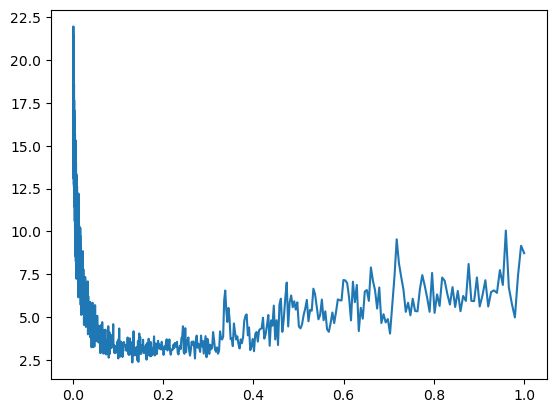

In [68]:
# Looking at the graph, the good learning rate turns out to be something around 0.0 and 0.2
# Which does not cause too much fluctuation in the loss
plt.plot(lri, lossi)

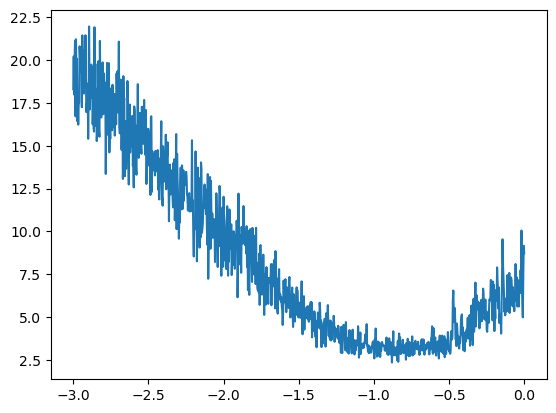

In [69]:
# The good exponential for learning rate should be somewhere inside the valley
plt.plot(lrei, lossi)

In [70]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

for i in range(10_000):
    # Minibatch construct
    # Tho the gradient won't be as good quality, it's still reliable
    ix = torch.randint(0, X.shape[0], (32,)) # random minibatch of size 32

    # Forward pass
    emb = C[X[ix]] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # we view this as log of counts
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 # Now that we are fairly confident that 0.1 is a good learning rate
    for p in parameters:
        p.data += -lr * p.grad 

# print(loss.item()) # This is the loss of the minibatch only

emb = C[X] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Y)
print(loss.item()) # This is the loss of the whole model

2.500380039215088


## Summary on strategy to pick learning rate

Try to see the lower bound learning rate and higher bound learning rate

Graph it like above and find an estimated good learning rate

Use it for training

Then, decay it by some levels: Like we can change it from 0.1 to 0.01 after training for many iterations

- After the model almost hits plateau, we refine learning to slower rate (learning rate decay) to further achieve better gradient

# Create train/val/test

A model with many parameters will likely be capable of overfitting (remembering) the examples and will not be able to generate new output if we sample from the model 

- Train: Training split

- Val: Validation/Dev split

- Test: Testing split

**NOTE**: Validation split is for tuning hyperparameters (like learning rate or regularization strength) and prevent overfitting

- Hyperparameters in this case are also the length of the hidden layer and the length of the embedding

- Try different hyperparameters to see what works best for the validation split

In [71]:
# train: 80%, val/dev: 10%, test: 10%

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) # n1 is breakpoint of 80% of words
n2 = int(0.9 * len(words)) # n2 is breakpiont of 90% of words

Xtr, Ytr = build_dataset(words[:n1]) # train
Xdev, Ydev = build_dataset(words[n1:n2]) # dev/validation
Xte, Xte = build_dataset(words[n2:]) # test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [72]:
len(words)

32033

In [73]:
n1

25626

In [74]:
n2

28829

In [75]:
n2-n1, len(words)-n2

(3203, 3204)

In [77]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

for i in range(30_000):
    # Minibatch construct
    # Tho the gradient won't be as good quality, it's still reliable
    ix = torch.randint(0, Xtr.shape[0], (32,)) # random minibatch of size 32

    # Forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # we view this as log of counts
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 # Now that we are fairly confident that 0.1 is a good learning rate
    for p in parameters:
        p.data += -lr * p.grad 

print(loss.item()) # This is the loss of the minibatch only

emb = C[Xtr] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Ytr)
print(loss.item()) # This is the loss of the whole model

emb = C[Xdev] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Ydev)
print(loss.item()) # This is the loss of the whole model

2.2425856590270996
2.439265251159668
2.439709424972534


# Scale up hidden layer

In [86]:
"""
Since the loss on training set and dev set are almost the same
We are probably underfitting, so we will scale the neural net to be bigger
"""
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) # Pump the hidden layer to be larger
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

for i in range(100_000):
    # Minibatch construct
    # Tho the gradient won't be as good quality, it's still reliable
    ix = torch.randint(0, Xtr.shape[0], (32,)) # random minibatch of size 32

    # Forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # we view this as log of counts
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 # Now that we are fairly confident that 0.1 is a good learning rate
    for p in parameters:
        p.data += -lr * p.grad 
    
    # Track stats
    lossi.append(loss.item())
    stepi.append(i)


print(loss.item()) # This is the loss of the minibatch only

emb = C[Xtr] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Ytr)
print(loss.item()) # This is the loss of the whole model

emb = C[Xdev] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Ydev)
print(loss.item()) # This is the loss of the whole model

10281
2.4334967136383057
2.304537534713745
2.3174779415130615


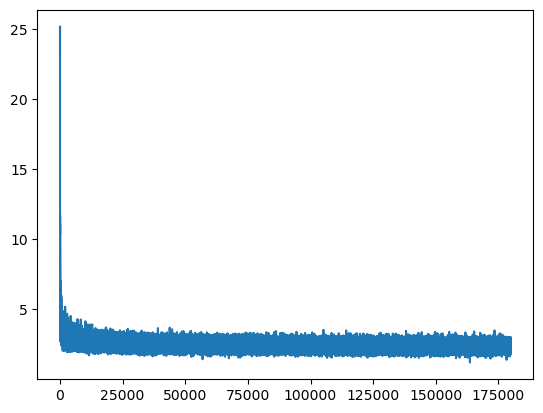

In [87]:
plt.plot(stepi, lossi)

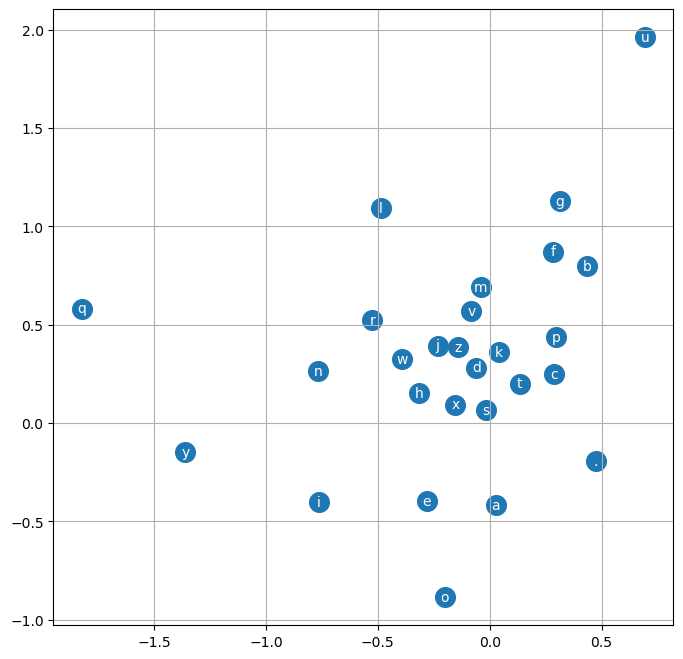

In [88]:
# Viisualize the embedding space

# One interesting thing is that our model is forming some ideas about the vowels and kinda clustering the a, e, i, o together
# The u is still out there LOL! 
# What it tells us is that the neural net treats these characters very similarly

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# Scale up embedding layer

In [89]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # Pump the embedding size
W1 = torch.randn((10 * 3, 200), generator=g) # Pump the hidden layer to be 200
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

11897


In [92]:
# Since even ater we scale up the hidden layer, the model does not perform as good as we expect
# So we guess that the embedding size is the bottle neck right now

for i in range(50_000):
    # Minibatch construct
    # Tho the gradient won't be as good quality, it's still reliable
    ix = torch.randint(0, Xtr.shape[0], (32,)) # random minibatch of size 32

    # Forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # we view this as log of counts
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.01 # Now that we are fairly confident that 0.1 is a good learning rate
    for p in parameters:
        p.data += -lr * p.grad 
    
    # Track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

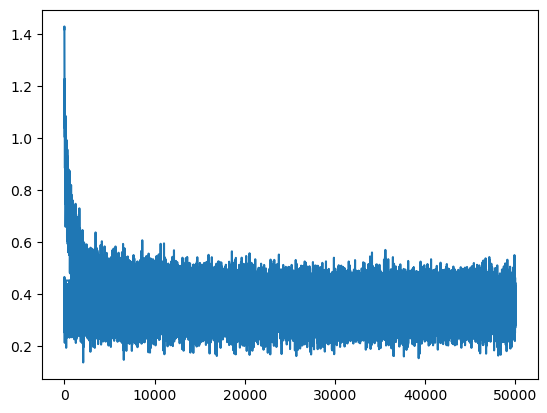

In [93]:
plt.plot(stepi, lossi)

In [95]:
print(loss.item()) # This is the loss of the minibatch only

emb = C[Xtr] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Ytr)
print(loss.item()) # This is the loss of the whole model

emb = C[Xdev] # 32, 3, 2 (32 examples, len-3 context window, len-2 embedding)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 # we view this as log of counts
loss = F.cross_entropy(logits, Ydev)
print(loss.item()) # This is the loss of the whole model

2.634084939956665
2.1915063858032227
2.221350908279419


# Summary on optimization

There are many knobs we can play around here:

- Length of hidden layer

- Size of embedding

- Length of context window

- Learning rate: Change it, init it one time, or even set breakpoints (like after how many iterations, rate is decay to a new lower number)

- More training iterations

- Batch size

# Sample from the model

In [96]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with . . .
    while True:
        # 1 is due to one example only
        emb = C[torch.tensor([context])] # (1, block_size, embedding size d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carpah.
amelle.
khi.
mili.
thaylenanden.
jazontlangerric.
kaqui.
nellana.
chaiiv.
kaleigh.
ham.
joce.
quinn.
shon.
rai.
adbi.
watelo.
dearynixah.
evellsa.
men.
